<h1 style="text-align: center;">The code in this notebook creates and saves the simulated data</h1>

In [7]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
import os
from fooof.sim import gen_power_spectrum
from Gating_Functions import extract_mask, extract_optimal_mask, perform_mlr
from fooof import FOOOF
from scipy.optimize import minimize_scalar
from Gating_Functions import extract_single_trial_peaks, extract_ERP_peak, compute_MNE_tfr, extract_tfr_band_gating
from Gating_Functions import Apply_WF_and_MLR, Get_Fooof_Parameters, Simulate_Background_Oscillations, Simulate_Signal_from_Gaussians, Combine_and_Scale_Signal
from Config import Get_Foof_config, perform_mlr_config, Signal_gaussian_config, combine_config


Extracting parameters from /Volumes/KetanData2/Processed files Thesis Pauline/Processed/GFAR_001_baseline.set...


/Users/ketanjaltare1/Desktop/PhD docs/Experiments/ValentinaProject/Gating_Functions.py:265: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(Path + ERP_files[index])


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Number of aperiodic parameters: 43
Number of periodic parameters: 43
43


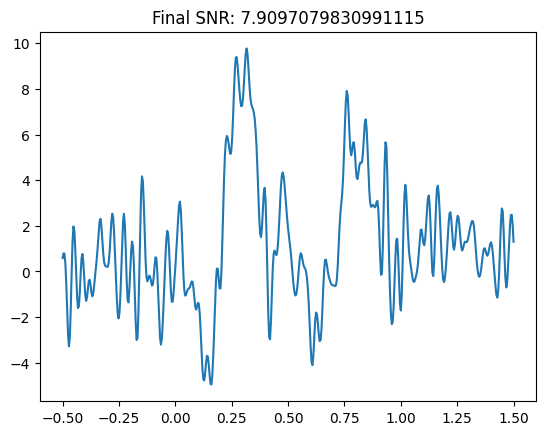

In [8]:
# Establish Simulation parameters - Check the limits of the parameters you want to use for the simulation
from Path_Config import Processed_folder as Path
Write_Path = Path + 'Simulated_Data/'
index = 0
aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(index, Path, config = Get_Foof_config)
times = epochs.times
sfreq = epochs.info['sfreq']
n_trials = len(aperiodic_params)
n_times = len(times)
print(f'Number of aperiodic parameters: {len(aperiodic_params)}')
print(f'Number of periodic parameters: {len(periodic_params)}')


Simulate_Background_config = {'noise_level': 0.2, 'freq_range': [1, 125], 'sfreq': sfreq }
Sim_sig_Background = Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, 
                                                      periodic_params, config = Simulate_Background_config)

Signal_gaussian_config['Gating_ratio'] = 0.5
Simulated_Signal = Simulate_Signal_from_Gaussians(n_trials, n_times, times, config=Signal_gaussian_config)

combine_config['Gaussian_noise_level'] = 1
Final_Signal, Final_SNR = Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background, times, 
                                                   sfreq, emperical_snr, config=combine_config)


plt.plot(times, Final_Signal.mean(axis=0))
plt.title(f'Final SNR: {Final_SNR}')
plt.show()


In [ ]:
# You have everything you need here to start rrunning the loop for the simulation
from Path_Config import Processed_folder as Path
Write_Path = Path + 'Simulated_Data/'
aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(0, Path)
times = epochs.times
sfreq = epochs.info['sfreq']

Gating_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Gaussian_noise_levels = np.round(np.linspace(0, 3, 10), 2)

for Gating_ratio in Gating_ratios:
    for Gaussian_noise_level in Gaussian_noise_levels:
        # Create a new folder for the simulated data with this gating ratio and noise level
        folder_name = f'Gating_{Gating_ratio}_Noise_{Gaussian_noise_level}'
        if not os.path.exists(os.path.join(Write_Path, folder_name)):
            os.makedirs(os.path.join(Write_Path, folder_name), exist_ok=True)
        Sub_write_path = os.path.join(Write_Path, folder_name)

        All_Simulated_Data, Extracted_metrics, Grand_Average_ERP = Simulate_Datasets(Path, Gating_ratio = Gating_ratio, 
                                                                                    Gaussian_noise_level = Gaussian_noise_level, 
                                                                                    times = times)


        mask, Final_Threshold, Relative_S1, Relative_S2, powspect = extract_optimal_mask(Grand_Average_ERP, times, sfreq, 
                                                                            winsize = .25, S1_onset=0, S2_onset=.5, 
                                                                            extract_mask_func = extract_mask, 
                                                                            threshold_drop=0.98, plot_signal = True)

        # Maybe save this figure in the folder for this iteration
        Threshold_values = np.linspace(.2, 1.00, 100)
        plt.plot(Threshold_values, Relative_S1, label = 'S1')
        plt.plot(Threshold_values, Relative_S2, label = 'S2')
        plt.axvline(x = Final_Threshold, color = 'r', linestyle = '--', label = 'GFAS S1 threshold')
        plt.axvline(x = Final_Threshold, color = 'g', linestyle = '--', label = 'GFAS S2 threshold')
        plt.title(f'Final Threshold: {Final_Threshold}')
        plt.legend()
        plt.savefig(os.path.join(Sub_write_path, 'relative_amplitudes.jpg'), dpi=300, bbox_inches='tight')
        plt.show()

        Extracted_WF_MLR = Apply_WF_and_MLR(All_Simulated_Data, times, sfreq, mask, plot_sample = False, Intercept = True)


        # save all the variables in the folder
        np.save(os.path.join(Sub_write_path, 'All_Simulated_Data.npy'), All_Simulated_Data)
        np.save(os.path.join(Sub_write_path, 'Extracted_metrics.npy'), Extracted_metrics)
        np.save(os.path.join(Sub_write_path, 'Grand_Average_ERP.npy'), Grand_Average_ERP)
        np.save(os.path.join(Sub_write_path, 'Extracted_WF_MLR.npy'), Extracted_WF_MLR)
        np.save(os.path.join(Sub_write_path, 'times.npy'), times)
        np.save(os.path.join(Sub_write_path, 'sfreq.npy'), sfreq)
        np.save(os.path.join(Sub_write_path, 'mask.npy'), mask)
        np.save(os.path.join(Sub_write_path, 'Final_Threshold.npy'), Final_Threshold)
        np.save(os.path.join(Sub_write_path, 'Relative_S1.npy'), Relative_S1)
        np.save(os.path.join(Sub_write_path, 'Relative_S2.npy'), Relative_S2)
        np.save(os.path.join(Sub_write_path, 'powspect.npy'), powspect)

